## GATHER DATA

In [16]:
#Import all python package used in the project 
import pandas as pd
import requests
import datetime
import os
import json
import numpy as np
import matplotlib.pyplot as plt

### Read in the provided datasets, and gather the image prediction dataset

In [17]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [18]:
ImageURL = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

response = requests.get(ImageURL)

with open(os.path.join(os.getcwd(), ImageURL.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)
    
#Read in tsv file    
image_prediction = pd.read_csv('image-predictions.tsv',sep='\t')

In [19]:
from tweepy import OAuthHandler
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

NameError: name 'tweepy' is not defined

In [ ]:
tweet_json = pd.read_json('tweet-json.txt', lines=True)
#Rename columns 
tweet_json.head()

## ASSESSING DATA

### Run various lines of code to visually inspect the data

In [20]:
twitter_archive.head(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [21]:
twitter_archive.tail(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2306,666835007768551424,NaN,NaN,2015-11-18 04:27:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are Peruvian Feldspars. Their names are ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666835007...,10,10,None,None,None,None,None
2307,666826780179869698,NaN,NaN,2015-11-18 03:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 simply brilliant pup https://t.co/V6ZzG4...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666826780...,12,10,None,None,None,None,None
2308,666817836334096384,NaN,NaN,2015-11-18 03:18:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeph. He is a German Boston Shuttlecoc...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666817836...,9,10,Jeph,None,None,None,None
2309,666804364988780544,NaN,NaN,2015-11-18 02:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jockson. He is a Pinnacle Sagittarius....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666804364...,8,10,Jockson,None,None,None,None
2310,666786068205871104,NaN,NaN,2015-11-18 01:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unfamiliar with this breed. Ears pointy af. Wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666786068...,2,10,None,None,None,None,None
2311,666781792255496192,NaN,NaN,2015-11-18 00:55:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Bacardi named Octaviath. Ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666781792...,10,10,a,None,None,None,None
2312,666776908487630848,NaN,NaN,2015-11-18 00:36:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Josep. He is a Rye Manganese mix. Can ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666776908...,5,10,Josep,None,None,None,None
2313,666739327293083650,NaN,NaN,2015-11-17 22:06:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lugan. He is a Bohemian Rhapsody. Very...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666739327...,10,10,Lugan,None,None,None,None
2314,666701168228331520,NaN,NaN,2015-11-17 19:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a golden Buckminsterfullerene named Jo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666701168...,8,10,a,None,None,None,None
2315,666691418707132416,NaN,NaN,2015-11-17 18:56:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Christoper. He is a spotted Penne. Can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666691418...,8,10,Christoper,None,None,None,None


In [22]:
image_prediction.head(50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [23]:
image_prediction.tail(50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2025,881906580714921986,https://pbs.twimg.com/media/DD0pWm9XcAAeSBL.jpg,1,Weimaraner,0.291539,True,Chesapeake_Bay_retriever,0.278966,True,koala,0.127017,False
2026,882045870035918850,https://pbs.twimg.com/media/DD2oCl2WAAEI_4a.jpg,1,web_site,0.949591,False,dhole,0.017326,False,golden_retriever,0.006941,True
2027,882268110199369728,https://pbs.twimg.com/media/DD5yKdPW0AArzX8.jpg,1,golden_retriever,0.762211,True,Labrador_retriever,0.098985,True,cocker_spaniel,0.017199,True
2028,882627270321602560,https://pbs.twimg.com/media/DD-40X3WAAAJPU5.jpg,1,Pembroke,0.542982,True,Chihuahua,0.251988,True,Cardigan,0.107699,True
2029,882762694511734784,https://pbs.twimg.com/media/DEAz_HHXsAA-p_z.jpg,1,Labrador_retriever,0.850050,True,Chesapeake_Bay_retriever,0.074257,True,flat-coated_retriever,0.015579,True
2030,882992080364220416,https://pbs.twimg.com/media/DEEEnIqXYAAiJh_.jpg,1,Eskimo_dog,0.466778,True,Siberian_husky,0.406044,True,dingo,0.073414,False
2031,883117836046086144,https://pbs.twimg.com/media/DEF2-_hXoAAs62q.jpg,2,golden_retriever,0.949562,True,Labrador_retriever,0.045948,True,kuvasz,0.002471,True
2032,883360690899218434,https://pbs.twimg.com/media/DEJT3FeXoAAtwUy.jpg,1,chow,0.987997,True,Tibetan_mastiff,0.007099,True,Newfoundland,0.002140,True
2033,883482846933004288,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True
2034,883838122936631299,https://pbs.twimg.com/media/DEQGFgAXUAAEvfi.jpg,1,Doberman,0.610946,True,miniature_pinscher,0.299603,True,kelpie,0.063020,True


In [24]:
tweet_json.head(50)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [25]:
tweet_json.tail(50)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
2304,NaN,NaN,2015-11-18 04:27:09,"[0, 144]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666835004639617025, 'id_str'...",222,False,These are Peruvian Feldspars. Their names are ...,NaN,...,0.0,NaN,NaN,NaN,83,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2305,NaN,NaN,2015-11-18 03:54:28,"[0, 50]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666826775146565632, 'id_str'...",266,False,12/10 simply brilliant pup https://t.co/V6ZzG4...,NaN,...,0.0,NaN,NaN,NaN,105,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2306,NaN,NaN,2015-11-18 03:18:55,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666817830839521280, 'id_str'...",540,False,This is Jeph. He is a German Boston Shuttlecoc...,NaN,...,0.0,NaN,NaN,NaN,267,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2307,NaN,NaN,2015-11-18 02:25:23,"[0, 135]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666804340162732032, 'id_str'...",250,False,This is Jockson. He is a Pinnacle Sagittarius....,NaN,...,0.0,NaN,NaN,NaN,95,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2308,NaN,NaN,2015-11-18 01:12:41,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666786064321900544, 'id_str'...",800,False,Unfamiliar with this breed. Ears pointy af. Wo...,NaN,...,0.0,NaN,NaN,NaN,521,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2309,NaN,NaN,2015-11-18 00:55:42,"[0, 107]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666781788895911936, 'id_str'...",404,False,This is a purebred Bacardi named Octaviath. Ca...,NaN,...,0.0,NaN,NaN,NaN,211,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2310,NaN,NaN,2015-11-18 00:36:17,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666776898802835456, 'id_str'...",368,False,This is Josep. He is a Rye Manganese mix. Can ...,NaN,...,0.0,NaN,NaN,NaN,186,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2311,NaN,NaN,2015-11-17 22:06:57,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666739322658398210, 'id_str'...",244,False,This is Lugan. He is a Bohemian Rhapsody. Very...,NaN,...,0.0,NaN,NaN,NaN,71,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2312,NaN,NaN,2015-11-17 19:35:19,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666701161143992320, 'id_str'...",449,False,This is a golden Buckminsterfullerene named Jo...,NaN,...,0.0,NaN,NaN,NaN,234,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2313,NaN,NaN,2015-11-17 18:56:35,"[0, 99]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666691411966824448, 'id_str'...",196,False,This is Christoper. He is a spotted Penne. Can...,NaN,...,0.0,NaN,NaN,NaN,51,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


### Use built in functions to programatically examine the data frames for tidiness and quality issues

In [26]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [27]:
twitter_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [28]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [29]:
twitter_archive['name'].value_counts()
twitter_archive['rating_denominator'].value_counts()
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [30]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
image_prediction[image_prediction['p1_dog'] == False]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,1.459380e-02,False,golden_retriever,7.958960e-03,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,2.784070e-01,True,groenendael,1.026430e-01,True
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,False,Irish_terrier,1.041090e-01,True,dingo,6.207120e-02,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,1.671750e-01,True,Chihuahua,8.695060e-02,True


## Quality issues:

###    image_prediction dataframe:
    
####    1. contains many animals that are not dogs
  
###    twitter_archive dataframe:
  
####    2. the date column has extra +0000, which is not needed

####    3. 'timestamp' is an object, and may need to be converted to a datetime    
    
####    4. the denominator table has a 0 and some other values that should be looked at
    
####    5. the numerator table has at least one 0 to correct or drop
    
####    6. some of the names ('a', 'the', 'an') do not appear to be correct
    
###    tweet_json dataframe:
    
####    7. the favorited column doesn't make sense, because it lists "False" even when there is a favorite count. I'm going to take a closer look at this column, and drop if it's stil confusing.
<br />

####    8. There are some very large numerators in the twitter_archive dataframe that will likely make the visuals I'm planning hard to read; these should be filtered out at the end before creating the visuals (I DID THIS WAY AT THE END)

## Tidiness issues:
    
####    1. The tweet_id is stored with multiple variables in the "extended_entities" column of the json_text dataframe
    
####   2. in the twitter_archive dataframe, "doggo", "floofer", "puppo", "pupper", should all be in one table
    
####    3. there are three separate dataframes we need to join

## CLEAN

## Make Data Copies

In [32]:
tweet_json_clean = tweet_json.copy()
twitter_archive_clean = twitter_archive.copy()
image_prediction_clean = image_prediction.copy()

### TIDINESS

### DEFINE

#### 1. The tweet_id is stored with multiple variables in the "extended_entities" column of the json_text dataframe. We need to extract the tweet_id with regex and create a new column with the tweet_id.

### CODE

In [33]:
#downselect to only the required columns
tweet_json_clean = tweet_json_clean[["extended_entities","retweet_count","favorite_count", "favorited"]]
#cast the "extended_entities" table as "string"
tweet_json_clean['extended_entities'] = tweet_json_clean['extended_entities'].astype(str)
tweet_json_clean.dtypes

extended_entities    object
retweet_count         int64
favorite_count        int64
favorited              bool
dtype: object

In [34]:
#use regex to extract the 18 digit tweet id
tweet_json_clean['tweet_id'] = tweet_json_clean['extended_entities'].str.extract(r'([0-9]{18})')

In [35]:
#drop the no longer needed "extended_entities" column
tweet_json_clean = tweet_json_clean.drop(['extended_entities'], axis=1)

### TEST

In [36]:
#test
tweet_json_clean.head()

,retweet_count,favorite_count,favorited,tweet_id
0,8853,39467,False,892420639486877696
1,6514,33819,False,892177413194625024
2,4328,25461,False,891815175371796480
3,8964,42908,False,891689552724799489
4,9774,41048,False,891327551943041024


### DEFINE

#### 2. in the twitter_archive dataframe, "doggo", "floofer", "puppo", "pupper", should all be in one table

### CODE

In [37]:
twitter_archive_clean.head(1000)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [38]:
#combine the columns into one new column named "stage"
twitter_archive_clean = twitter_archive_clean.replace('None', np.nan)
twitter_archive_clean['stage'] = twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].fillna('').sum(axis=1).astype(str)
#Drop deprecated columns
twitter_archive_clean = twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [39]:
#Clean up incorrect lables, like "doggopupper"
twitter_archive_clean['stage'].value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

In [40]:
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'

### TEST

In [41]:
twitter_archive_clean.head(1000)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


In [42]:
#Clean up incorrect lables, like "doggopupper"
twitter_archive_clean['stage'].value_counts()

                  1976
pupper             245
doggo               83
puppo               29
doggo, pupper       12
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: stage, dtype: int64

### QUALITY

#### image_prediction dataframe:

### DEFINE

#### 1. contains many animals that are not dogs

### CODE

In [43]:
image_prediction_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [44]:
#filter out non dog predictions
image_prediction_clean = image_prediction_clean[image_prediction['p1_dog'] == True]

### TEST

In [45]:
#test
image_prediction_clean['p2'].value_counts()

Labrador_retriever                94
golden_retriever                  76
Cardigan                          70
Pomeranian                        39
French_bulldog                    35
Chesapeake_Bay_retriever          34
Chihuahua                         33
miniature_poodle                  33
Siberian_husky                    33
cocker_spaniel                    33
toy_poodle                        28
beagle                            28
collie                            27
Eskimo_dog                        25
kuvasz                            24
Pembroke                          22
Italian_greyhound                 21
Pekinese                          20
malinois                          19
toy_terrier                       19
American_Staffordshire_terrier    19
Samoyed                           18
chow                              17
miniature_pinscher                17
Norwegian_elkhound                16
Boston_bull                       16
Irish_terrier                     16
S

twitter_archive dataframe:

### DEFINE

#### 2. the date column has extra +0000, which is not needed

### CODE

In [46]:
twitter_archive_clean.timestamp  = twitter_archive_clean.timestamp.str.strip('+0000')
#check 0's removed
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


### TEST

In [47]:
#check 0's removed
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


### DEFINE

#### 3. 'timestamp' is an object, and may need to be converted to a datetime

### CODE

In [48]:
#convert 'timestamp' to "datetime"
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean['timestamp'])

### TEST

In [49]:
#check datatype
twitter_archive_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
stage                                 object
dtype: object

### DEFINE

#### 4. the denominator table has a 0 and some other values that should be looked at

### CODE

In [50]:
pd.set_option("max_colwidth", 100)
twitter_archive_clean[twitter_archive_clean['rating_denominator'] == 0]['text']

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object

#### This shows that the record with a 0 for the denominator should be 10, and the numerator should be 13

In [51]:
#upate denominator and numerator to reflect accurate rating
twitter_archive_clean.at[313,'rating_denominator']=10
twitter_archive_clean.at[313,'rating_numerator']=13

### TEST

In [52]:
#check
twitter_archive_clean.iloc[[313]]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,13,10,NaN,


### DEFINE

#### 5. the numerator table has a 0 and some very large values that should be looked at

### CODE

In [53]:
pd.set_option("max_colwidth", 200)
twitter_archive_clean[twitter_archive_clean['rating_numerator'] == 0]['text']

315           When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
1016    PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX
Name: text, dtype: object

I plan to use all ratings with valid denominators and numerators, and since these wont yield a real value, I am going to drop these records

In [54]:
#drop rows with 0 numerator
twitter_archive_clean.drop(twitter_archive_clean.index[[315, 1016]], inplace=True)

### TEST

In [55]:
#check to make sure no more 0 numerators
twitter_archive_clean[twitter_archive_clean['rating_numerator'] == 0]['text']

Series([], Name: text, dtype: object)

### DEFINE

#### 6. Some of the names ('a', 'the', 'an', 'very', 'just', 'one', 'quite', 'mad', 'not', 'my', 'old', 'by', 'this', 'unacceptable', 'his', 'all', 'light') do not appear to be correct

### CODE

In [56]:
with pd.option_context("display.max_rows", None):
    display(twitter_archive_clean['name'].value_counts().to_frame())

,name
a,55
Charlie,12
Oliver,11
Cooper,11
Lucy,11
Penny,10
Lola,10
Tucker,10
Winston,9
Bo,9


### TEST

In [57]:
# I noticed all the incorrect names were all lower case, so I wrote the below to check my list above. There are too many for me to want to fix manually, but I can at least drop them all at once in the future if I need to. I do not think I will need the name for my visuals... If one of the incorrectly named dogs is featured in my visuals, I'll correct the name if possible, or list as "Unknown"
twitter_archive_clean[twitter_archive_clean['name'].str.islower()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,pupper
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10,10,not,
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1",14,10,one,
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024703037440/photo/1,11,10,incredibly,
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,http...",13,10,a,
682,788552643979468800,NaN,NaN,2016-

### DEFINE

#### 7. the favorited column doesn't make sense, because it lists "False" even when there is a favorite count. I'm going to take a closer look at this column, and drop if it's stil confusing

### CODE

In [58]:
#explore True values in the "favorited column", if there are any
tweet_json_clean[tweet_json_clean['favorited'] == True]

,retweet_count,favorite_count,favorited,tweet_id
21,12082,46959,True,887517108413886465
61,4533,28150,True,880095777175076864
63,10,315,True,NaN
454,9366,0,True,NaN
471,9366,33961,True,816450564926164996
588,6478,0,True,NaN
787,6478,24167,True,774314388044058624
1005,619,2545,True,747600758972026880


#### There are very few records where "favorited" is true, and the column still doesn't seem to make sense. I am going to drop this column.

In [59]:
tweet_json_clean.drop(['favorited'], axis = 1, inplace=True)

### TEST

In [60]:
#make sure the column is gone
tweet_json_clean.head()

,retweet_count,favorite_count,tweet_id
0,8853,39467,892420639486877696
1,6514,33819,892177413194625024
2,4328,25461,891815175371796480
3,8964,42908,891689552724799489
4,9774,41048,891327551943041024


### FINAL TIDINESS AND QUALITY FIXES

#### Join all tables into one table

In [61]:
#drop the row(s) with no tweet_id:
tweet_json_clean.dropna(subset = ["tweet_id"], inplace=True)

In [62]:
#ensure all 'tweet_id' columns are the same data type:
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(float)
tweet_json_clean.tweet_id = tweet_json_clean.tweet_id.astype(float)
image_prediction_clean.tweet_id = image_prediction_clean.tweet_id.astype(float)

In [63]:
tweet_json_clean[['retweet_count', 'favorite_count']] = tweet_json_clean[['retweet_count', 'favorite_count']].astype(float)
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2353
Data columns (total 3 columns):
retweet_count     2073 non-null float64
favorite_count    2073 non-null float64
tweet_id          2073 non-null float64
dtypes: float64(3)
memory usage: 64.8 KB


In [64]:
twitter_archive_clean[['rating_numerator', 'rating_denominator']] = twitter_archive_clean[['rating_numerator', 'rating_denominator']].astype(float)
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2354 non-null float64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2354 non-null datetime64[ns]
source                        2354 non-null object
text                          2354 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2295 non-null object
rating_numerator              2354 non-null float64
rating_denominator            2354 non-null float64
name                          1611 non-null object
stage                         2354 non-null object
dtypes: datetime64[ns](1), float64(7), object(6)
memory usage: 275.9+ KB


In [65]:
#concat all dataframes
master_clean = pd.concat([twitter_archive_clean, tweet_json_clean, image_prediction_clean], axis=1)

In [66]:
#check concat
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                      2354 non-null float64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2354 non-null datetime64[ns]
source                        2354 non-null object
text                          2354 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2295 non-null object
rating_numerator              2354 non-null float64
rating_denominator            2354 non-null float64
name                          1611 non-null object
stage                         2354 non-null object
retweet_count                 2073 non-null float64
favorite_count                2073 non-null float64
tweet_id                      2073 non-null float64
tweet_id       

In [67]:
#check combined dataframe
master_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,8.924206e+17,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,1.0,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,8.921774e+17,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,8.918152e+17,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,1.0,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,8.916896e+17,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,1.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,8.913276e+17,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,1.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [68]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                      2354 non-null float64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2354 non-null datetime64[ns]
source                        2354 non-null object
text                          2354 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2295 non-null object
rating_numerator              2354 non-null float64
rating_denominator            2354 non-null float64
name                          1611 non-null object
stage                         2354 non-null object
retweet_count                 2073 non-null float64
favorite_count                2073 non-null float64
tweet_id                      2073 non-null float64
tweet_id       

In [69]:
#Remove retweets!
master_clean = master_clean[master_clean.retweeted_status_id.isnull()]

In [70]:
#Check retweets are gone
master_clean[master_clean['retweeted_status_id'] == False].count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
stage                         0
retweet_count                 0
favorite_count                0
tweet_id                      0
tweet_id                      0
jpg_url                       0
img_num                       0
p1                            0
p1_conf                       0
p1_dog                        0
p2                            0
p2_conf                       0
p2_dog                        0
p3                            0
p3_conf                       0
p3_dog                        0
dtype: int64

## Store cleaned data

In [71]:
#write cleaned dataframe to a new .csv file
master_clean.to_csv('twitter_archive_master.csv')

### FINAL QUALITY ISSUE

### DEFINE

####    8. There are some very large numerators that will make my planned visuals hard to read; these should be filtered out at the end before creating the visuals

### CODE

In [72]:
#read in new file for final cleanup, insights and visualizations
master_clean = pd.read_csv('twitter_archive_master.csv')
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 30 columns):
Unnamed: 0                    2175 non-null int64
tweet_id                      2173 non-null float64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2173 non-null object
source                        2173 non-null object
text                          2173 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null float64
expanded_urls                 2115 non-null object
rating_numerator              2173 non-null float64
rating_denominator            2173 non-null float64
name                          1495 non-null object
stage                         344 non-null object
retweet_count                 1921 non-null float64
favorite_count                1921 non-null float64
tweet_id.1                    1

In [73]:
#remove outliers data so visuals are easier to read
master_no_outlier = master_clean[master_clean['rating_numerator']<20]

### TEST

In [74]:
master_no_outlier[master_no_outlier['rating_numerator']<20]

,Unnamed: 0,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0,8.924206e+17,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,...,1.0,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,1,8.921774e+17,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,...,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,2,8.918152e+17,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,...,1.0,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,3,8.916896e+17,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,...,1.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,4,8.913276e+17,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,...,1.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,5,8.910880e+17,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,...,1.0,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,6,8.909719e+17,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,8.907292e+17,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,...,1.0,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,8,8.906092e+17,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,8.902403e+17,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,NaN,NaN,NaN,...,1.0,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.0820

## Analyze and Visualize

### Visualization to check for correlation between ratings and retweet_count

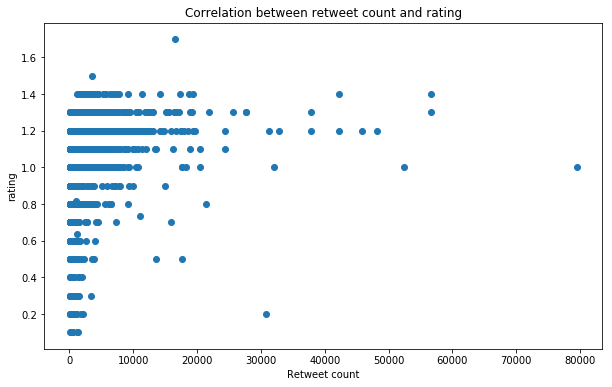

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y = (master_no_outlier['rating_numerator']/master_no_outlier['rating_denominator']), x = master_no_outlier['retweet_count'])
plt.xlabel("Retweet count")
plt.ylabel("rating")
plt.title("Correlation between retweet count and rating")

plt.show()

### Visualization to check for correlation between ratings and favorite_count

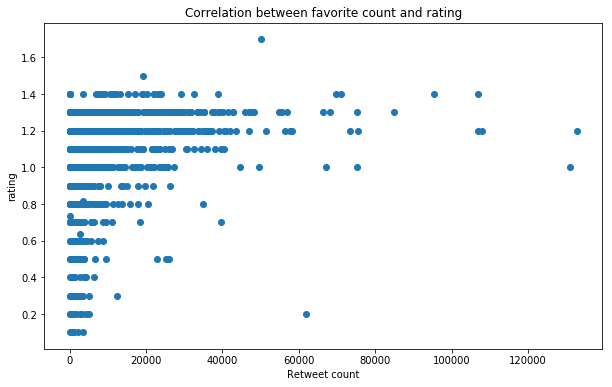

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y = (master_no_outlier['rating_numerator']/master_no_outlier['rating_denominator']), x = master_no_outlier['favorite_count'])
plt.xlabel("Retweet count")
plt.ylabel("rating")
plt.title("Correlation between favorite count and rating")

plt.show()

### Which dogs are in the top ten for highest rating?

In [77]:
master_clean['score'] = master_clean['rating_numerator']/master_clean['rating_denominator']
master_clean[['p1', 'name', 'rating_numerator', 'rating_denominator', 'score']].nlargest(10, 'score')

,p1,name,rating_numerator,rating_denominator,score
804,Blenheim_spaniel,Atticus,1776.0,10.0,177.600000
163,Airedale,NaN,666.0,10.0,66.600000
162,Brabancon_griffon,NaN,420.0,10.0,42.000000
1895,NaN,NaN,420.0,10.0,42.000000
246,NaN,NaN,182.0,10.0,18.200000
558,Labrador_retriever,Logan,75.0,10.0,7.500000
429,golden_retriever,Sam,24.0,7.0,3.428571
617,NaN,Sophie,27.0,10.0,2.700000
1533,Norwegian_elkhound,NaN,26.0,10.0,2.600000
52,Chesapeake_Bay_retriever,NaN,17.0,10.0,1.700000


### What are the top ten highest rated breeds?

In [78]:
cutest_breeds = master_clean[['p1', 'name', 'score']].groupby('p1', as_index = False, sort = False).mean()
cutest_breeds.nlargest(10, 'score')
#cutest_breeds[['name', 'rating_numerator', 'rating_denominator', 'score']].nlargest(10,'score')

,p1,score
21,Blenheim_spaniel,17.054545
56,Brabancon_griffon,14.733333
29,Airedale,7.640000
19,black-and-tan_coonhound,1.300000
81,standard_schnauzer,1.300000
38,Tibetan_terrier,1.275000
33,giant_schnauzer,1.266667
7,miniature_poodle,1.250000
64,Sussex_spaniel,1.250000
68,Norfolk_terrier,1.220000


### What are the botten 10 rated breeds?

In [79]:
cutest_breeds.nsmallest(10, 'score')

,p1,score
108,clumber,0.400000
106,silky_terrier,0.800000
103,Bedlington_terrier,0.840000
3,Rhodesian_ridgeback,0.850000
101,Appenzeller,0.900000
69,Old_English_sheepdog,0.945455
83,Boston_bull,0.950000
66,Norwich_terrier,0.950000
37,Saint_Bernard,0.957143
100,briard,0.966667


## Insights

### Insight 1: There appears to be a correlation between retweet count and the rating the dog receives. Higher ratings seem to correlate with higher retweet count.

### Insight 2: There appears to be a correlation between favorite count and the rating the dog receives. Higher ratings seem to correlate with higher favorite count.

### Insight 3:  Terriers are represented in the both the top and bottom ten rated breeds.